In [1]:
from lshash.lshash import LSHash

In [12]:
# 8 => 6
lsh = LSHash(2, 8)

In [15]:
lsh.index([1.2,2,3,4,5,6,7,8])
lsh.index([1,3,3,4,5,6,7,8])
lsh.index([1,5,3,4,5,6,7,8])
lsh.index([45,5,3,4,5,88,7,8])

In [17]:
out = lsh.query([1,2,3,4,5,6,7,7], 4)

In [19]:
out.index

<function list.index(value, start=0, stop=9223372036854775807, /)>

In [18]:
dir(out)

['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__delitem__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__iadd__',
 '__imul__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__reversed__',
 '__rmul__',
 '__setattr__',
 '__setitem__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'append',
 'clear',
 'copy',
 'count',
 'extend',
 'index',
 'insert',
 'pop',
 'remove',
 'reverse',
 'sort']

In [42]:
from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections
import numpy

# Dimension of our vector space
dimension = 10

# Create a random binary hash with 10 bits
rbp = RandomBinaryProjections('rbp', 2)

# Create engine with pipeline configuration
engine = Engine(dimension, lshashes=[rbp])

# Index 1000000 random vectors (set their data to a unique string)
for index in range(20):
    v = numpy.random.randn(dimension)
    engine.store_vector(v, index)

# Create random query vector
query = numpy.random.randn(dimension)

# Get nearest neighbours
N = engine.neighbours(query)

In [45]:
N[0][:2]

(array([-0.16924368,  0.25002924, -0.32553698, -0.11809647, -0.19562842,
         0.49343583,  0.48452211,  0.35533457,  0.36083939, -0.12626187]),
 13)

In [18]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

import pickle as pk
from PIL import Image
import random

PyTorch Version:  1.0.0
Torchvision Version:  0.2.1


In [19]:
# Detect if we have a GPU available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device:',device)

batch_size = 32

device: cuda


In [37]:
# save to loacl file
# save_path = './features/maxPooling_UcRemote21-train-resnet'
save_path = './features/UcRemote21-train-resnet'

def save_data(file, data):
    f = open(file, 'wb+')
    pk.dump(data, f, 0)
    f.close()


def extract_features(model, loader):
    since = time.time()
    features = torch.FloatTensor()
         
    model.eval()

    # Iterate over data.
    for inputs, labels in loader:

        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        ff = outputs.data.cpu()
        # norm feature
        fnorm = torch.norm(ff, p=2, dim=1, keepdim=True)
        ff = ff.div(fnorm.expand_as(ff))
        features = torch.cat((features, ff), 0)

    time_elapsed = time.time() - since
    print('Feature extraction complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    
    return features

if os.path.exists(save_path):
    fo = open(save_path, 'rb')
    features = pk.load(fo, encoding='bytes')
    fo.close()
    print("Load features.")
else:
    features = extract_features(pretrained_net, Gallery_loader)
    save_data(save_path, features)
    print("Save features to %s" % (save_path))

Load features.


In [74]:
features[0].shape

torch.Size([512])

## 二值化向量

In [59]:
def Binary_Vector(vector): # tensor
    v_mean = vector.mean()
    v_mean = v_mean.expand_as(vector)
    return vector > v_mean

In [ ]:
## example

In [55]:
X = torch.randn(5)

In [56]:
X

tensor([-0.2255,  0.3962, -0.2262, -0.5220, -0.9578])

In [57]:
Y = Binary_Vector(X)

In [58]:
Y

tensor([1, 1, 1, 0, 0], dtype=torch.uint8)

## 汉明距离

In [117]:
def hammingDistance(vector1, vector2):
    return (vector1 != vector2).sum()

In [118]:
x = torch.tensor([1,1,0,1,0,1,0,0,1,1])
y = torch.tensor([0,1,1,0,0,0,1,1,1,0])

In [119]:
hammingDistance(x , y)

tensor(7)

In [75]:
# 提取目标图像的特征  修
def query_feature(input):
    x = input

    x = x.unsqueeze(dim=0)
    x.requires_grad = False

    x.to(device)
    pretrained_net.to('cpu')
    pretrained_net.eval()
    
    pre = pretrained_net(x)
    pre = pre.data.cpu()
    # norm feature
    prenorm = torch.norm(pre, p=2, dim=1, keepdim=True)
    pre = pre.div(prenorm.expand_as(pre))
    return pre

In [76]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
def tensor2image(data):
    # 因为做了归一化，要返回标准tensor
    for i in range(len(data)): # (x-m)/s = y   x = 
        data[i] = data[i] * std[i] + mean[i]
    img = transforms.ToPILImage()(data).convert('RGB')
    plt.imshow(img)

In [77]:
# mAP... and  准确率 k = 5 10 20
def compute_AP_and_P(list, label):
    P_three = []
    true_size = 0.0
    AP = 0.0
    num = 1
    for i in range(len(list)):
#         if num == 19: # 在这里正例总共20个
#             break
        # 排除自身这张图片
        if i == 0:
            continue
        if list[i] == label:
            true_size += 1.
            AP += true_size / (i)
#             num = num + 1
        if i == 5:
            P_three.append(true_size/(i))
        if i == 10:
            P_three.append(true_size/(i))
        if i == 20:
            P_three.append(true_size/(i))
    if true_size == 0.0:
        return 0
    return AP/true_size, P_three

## 二值化后使用汉明距离计算相似度

In [78]:
# Dimension of our vector space
dimension = 10

# Create a random binary hash with 10 bits
rbp = RandomBinaryProjections('rbp', 2)

# Create engine with pipeline configuration
engine = Engine(dimension, lshashes=[rbp])

# Index 1000000 random vectors (set their data to a unique string)
for index in range(20):
    v = numpy.random.randn(dimension)
    engine.store_vector(v, index)

# Create random query vector
query = numpy.random.randn(dimension)

# Get nearest neighbours
N = engine.neighbours(query)
# 计算目标图片与数据库中每张图像的余弦相似度
def search_similar(target, features):
    record = []
    target_Binary = Binary_Vector(target)
    for i in range(len(features)):
        features_i_Binary = Binary_Vector(features[i])
        record.append(hammingDistance(target_Binary, features_i_Binary) )
    return record

In [129]:
## test
k = 0
pre = query_feature(Gallery_dataset[k][0])
pre = pre.view(512)

k = 1
pre1 = query_feature(Gallery_dataset[k][0])
pre1 = pre1.view(512)

k = 200
pre200 = query_feature(Gallery_dataset[k][0])
pre200 = pre200.view(512)

In [130]:
pre = Binary_Vector(pre)
pre1 = Binary_Vector(pre1)
pre200 = Binary_Vector(pre200)
hammingDistance(pre, pre1)

tensor(95)

In [131]:
hammingDistance(pre, pre200)

tensor(235)

In [80]:
from torch.utils.data import Dataset, DataLoader
def dataLoader():
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    # mean = [0.485, 0.456, 0.406]  std = [0.229, 0.224, 0.225]
    test_augs = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        normalize
    ])
    Gallery_dataset = datasets.ImageFolder(root='../数据集/UCMerced_LandUse/data/test', transform=test_augs)
#     Gallery_dataset = datasets.ImageFolder(root='../数据集/Google dataset of SIRI-WHU_earth_im_tiff/12class_tif', transform=test_augs)
    return Gallery_dataset
Gallery_dataset = dataLoader()
Gallery_loader = DataLoader(Gallery_dataset,
                           batch_size = 32, shuffle=False)

In [83]:
## 加载模型：resnet34_whurisi_remote_finetune_
pretrained_net = models.resnet34(pretrained=True)
pretrained_net.fc = nn.Linear(512, 21)

# PATH = "./my_model/UcRemote_resnet34_fine-tune.pt"  # 默认使用平均池化

pretrained_net.avgpool = nn.MaxPool2d(kernel_size=7, stride=1, padding=0)
PATH = "./my_model/maxPooling_UcRemote_resnet34_fine-tune.pt"  # 使用最大池化

pretrained_net.fc = nn.Sequential()
pretrained_net.load_state_dict(torch.load(PATH))
pretrained_net = pretrained_net.to(device)

target label: 12
found label : 18 12 11 6 4 19 11 20 6 4 6 12 6 18 20 6 12 6 11 6 12 6 6 12 6 6 12 12 12 12 12 12 11 6 12 4 12 12 12 12 (0.3411495656767184, [0.2, 0.1, 0.2])


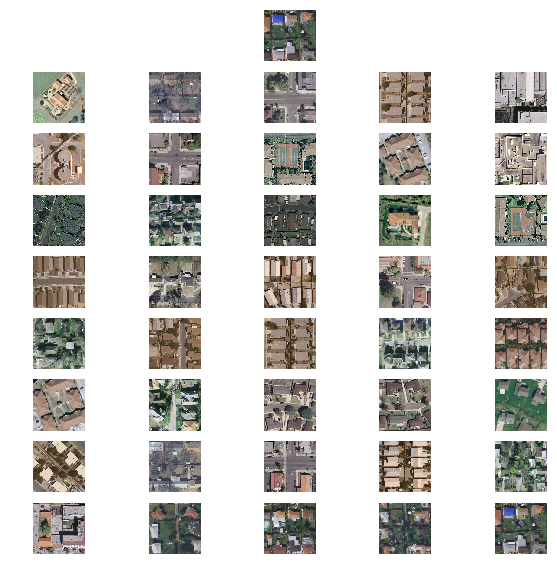

In [132]:
k = 250
plt.subplots(figsize=(10, 10))
print("target label:",Gallery_dataset[k][1])
plt.subplot(9,5,3)
tensor2image(Gallery_dataset[k][0])
plt.axis('off')

pre = query_feature(Gallery_dataset[k][0])
pre = pre.view(pre.size(1))
res = search_similar(pre, features)
sim = np.argsort(res)[:40]  # 取最相似的20张  40

preLabelList = []
i = 6
print('found label : ',end='')
for index in range(len(sim)):
    re = sim[len(sim)-1-index]
    plt.subplot(9, 5, i)      
    tensor2image(Gallery_dataset[re][0])
    print('%s ' % (Gallery_dataset[re][1]),end='')
    preLabelList.append(Gallery_dataset[re][1])
    i += 1
    plt.axis('off')
print(compute_AP_and_P(preLabelList, Gallery_dataset[k][1]))
plt.show()